In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as dr
import datetime as dt
import mplfinance as mpf
import matplotlib.pyplot as plt
import statistics

In [2]:
start= dt.datetime(2018,1,1)
end= dt.datetime.now()

In [3]:
df=dr.DataReader('BTC-USD', 'yahoo', start, end)

In [4]:
setup = dict(type='candle',volume=True,mav=(9,26,52), figscale=2)

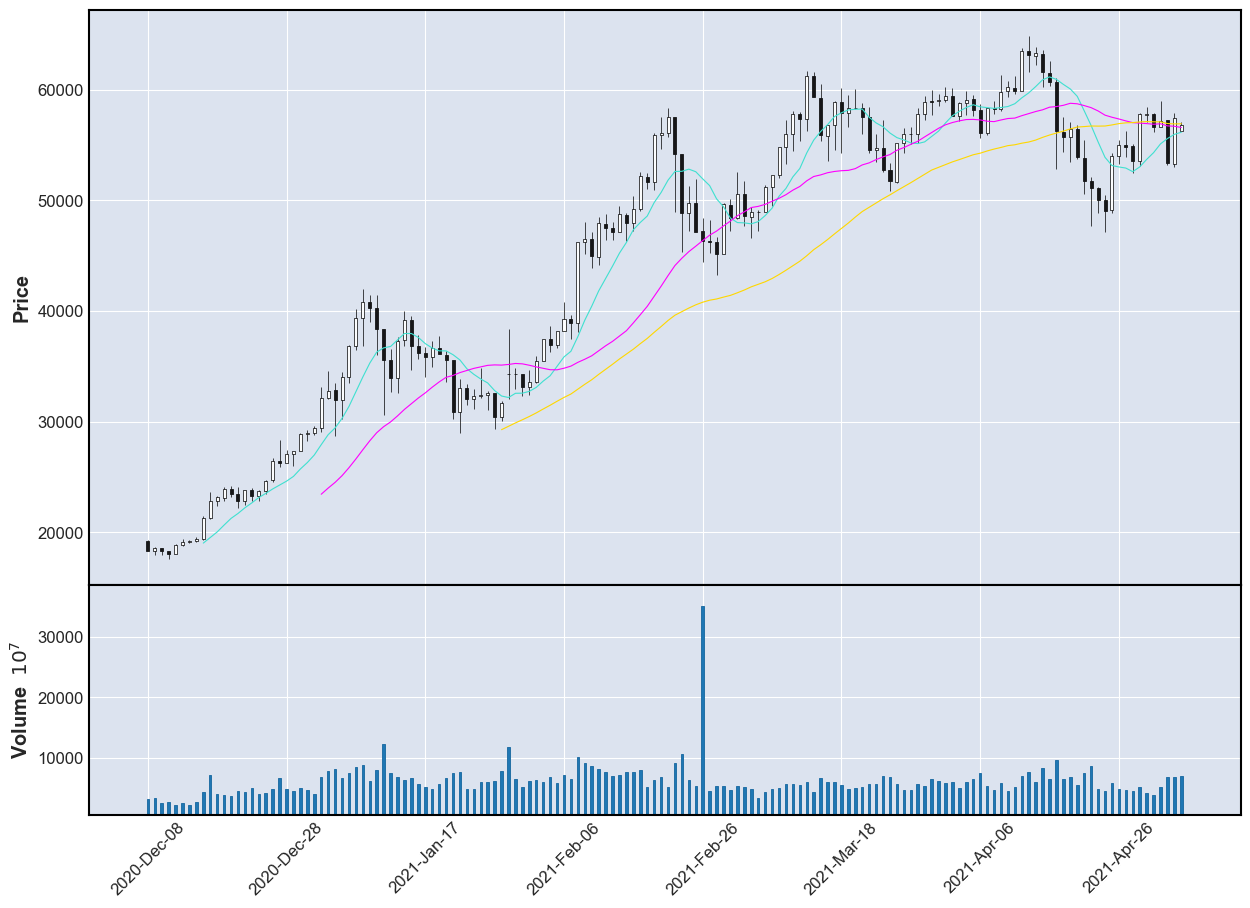

In [5]:
mpf.plot(df.iloc[-150:],**setup,scale_width_adjustment=dict(volume=0.4,candle=1))

In [6]:
def relative_strength_index(data, n):
    data['row_no']=[i for i in range(len(data))]
    j = 1
    change = [0]
    while j <= data['row_no'][-1]:
        change.append(data['Close'].iloc[j] - data['Close'].iloc[j - 1])
        j = j + 1

    j = 1
    UM = [0]
    DM = [0]
    while j <= data['row_no'][-1]:
        if change[j] > 0:
            UM.append(change[j])
        else:
            UM.append(0)
        j = j + 1

    j = 1
    while j <= data['row_no'][-1]:
        if change[j] < 0:
            DM.append(abs(change[j]))
        else:
            DM.append(0)
        j = j + 1

    AUM = [0] * n
    ADM = [0] * n
    RS = [0] * n
    RSI = [0] * n

    AUM.append(statistics.mean(UM[0:n]))
    ADM.append(statistics.mean(DM[0:n]))

    if ADM[-1] != 0:
        RS.append(AUM[-1] / ADM[-1])
    else:
        RS.append(1000000)

    RSI.append(100 - 100 / (1 + RS[-1]))

    j = n + 1
    while j <= data['row_no'][-1]:
        AUM.append((13 * AUM[j - 1] + UM[j]) / n)
        ADM.append((13 * ADM[j - 1] + DM[j]) / n)
        if ADM[j] != 0:
            RS.append(AUM[j] / ADM[j])
        else:
            RS.append(1000000)

        RSI.append(100 - 100 / (1 + RS[j]))

        j = j + 1

    data[f'RSI_{n}']=[i for i in RSI]
    return data

In [7]:
df=relative_strength_index(df, 14)

In [8]:
def exponential_moving_average(data, n):
    data['row_no']=[i for i in range(len(data))]

    alpha = 2 / (1 + n)

    PDM = [0]
    NDM = [0]
    i = 1
    while i <= data['row_no'][-1]:
        if (data['High'].iloc[i] - data['High'].iloc[i - 1]) > (data['Low'].iloc[i - 1] - data['Low'].iloc[i]):
            PDM.append(max(0, data['High'].iloc[i] - data['High'].iloc[i - 1]))
        else:
            PDM.append(0)

        if (data['High'].iloc[i] - data['High'].iloc[i - 1]) < (data['Low'].iloc[i - 1] - data['Low'].iloc[i]):
            NDM.append(max(0, data['Low'].iloc[i - 1] - data['Low'].iloc[i]))
        else:
            NDM.append(0)

        i = i + 1

    i = (n - 1)
    EMA = [0] * (n - 1)
    while i <= data['row_no'][-1]:
        if i == (n - 1):
            EMA.append(sum(data['Close'].iloc[i - n + 1:i + 1]) / n)
        else:
            EMA.append(data['Close'].iloc[i] * alpha + EMA[i - 1] * (1 - alpha))

        i = i + 1
    EMA = pd.Series(EMA, name='EMA_' + str(n))
    return EMA


In [9]:
EMA_12 = exponential_moving_average(df, 12)
EMA_26 = exponential_moving_average(df, 26)
EMA_diff_MACD_12_26_9 = EMA_12 - EMA_26
df['MACD']=[i for i in EMA_diff_MACD_12_26_9]

In [10]:
def MACD_signal(data, a, b, n):
    data['row_no']=[i for i in range(len(data))]
    
    alpha = 2 / (1 + n)
    i = (b - 1) + n - 1
    MACD = [0] * ((b - 1) + n - 1)
    while i <= data['row_no'][-1]:
        if i == ((b - 1) + n - 1):
            MACD.append(sum(data[f'MACD'].iloc[i - n + 1:i + 1]) / n)
        else:
            MACD.append(data[f'MACD'].iloc[i] * alpha + MACD[i - 1] * (1 - alpha))

        i = i + 1

    data[f'MACD_Signal']=[i for i in MACD]
    return data

In [11]:
df = MACD_signal(df, 12, 26, 9)

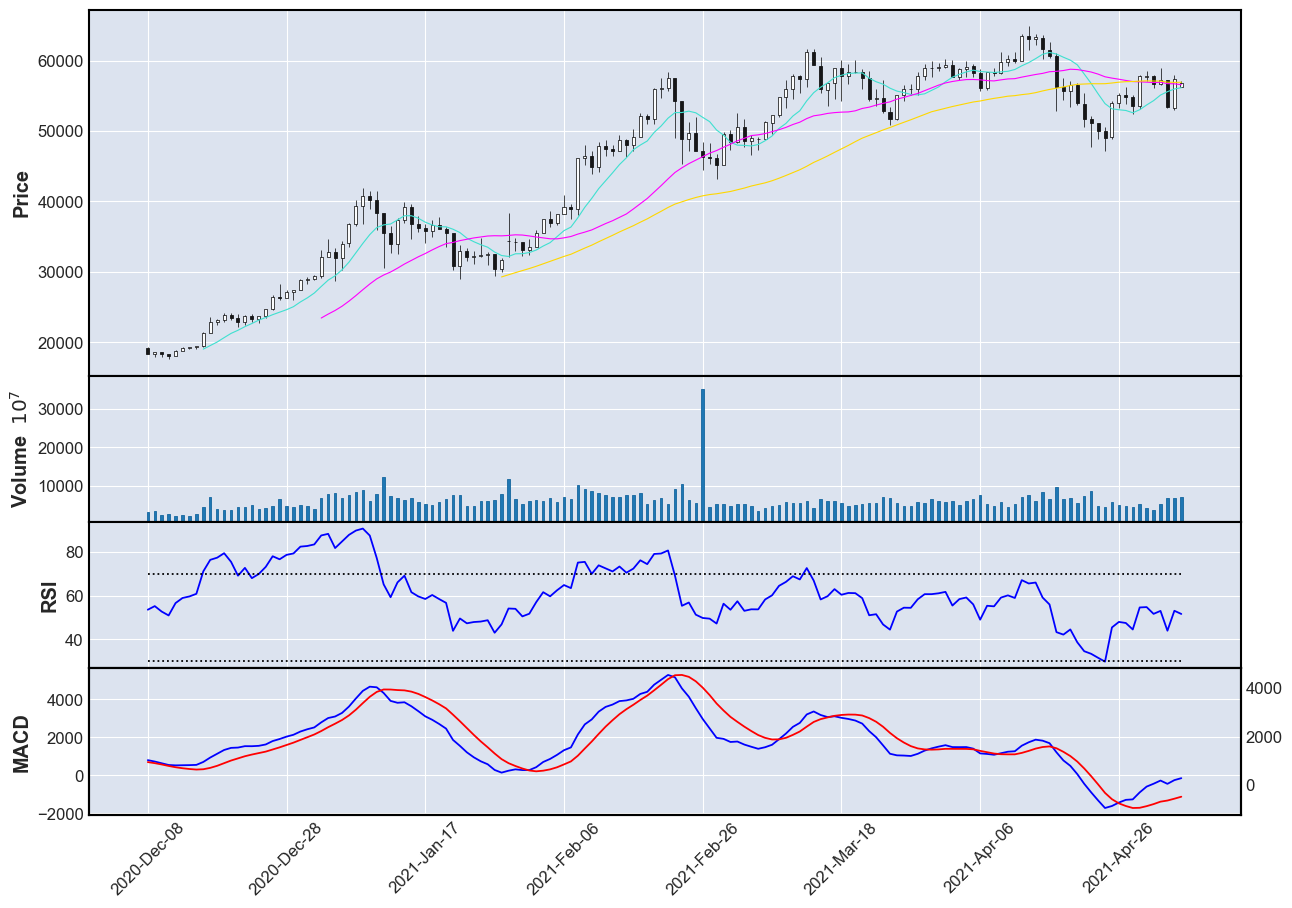

In [13]:
apdict = [mpf.make_addplot(df['RSI_14'].iloc[-150:],panel=2,color='b', ylabel='RSI'),
          mpf.make_addplot([70]*150,panel=2,color='black', linestyle='dotted'),
          mpf.make_addplot([30]*150,panel=2,color='black', linestyle='dotted'),
        mpf.make_addplot(df['MACD'].iloc[-150:],panel=3,color='b', ylabel='MACD'),
        mpf.make_addplot(df['MACD_Signal'].iloc[-150:],panel=3,color='r')]

mpf.plot(df.iloc[-150:],**setup,scale_width_adjustment=dict(volume=0.4,candle=1),addplot=apdict)